In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()


Using TensorFlow backend.


In [2]:
#Download MPRA-DragoNN data

#!wget http://mitra.stanford.edu/kundaje/projects/mpra/data/train.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/mpra/data/valid.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/mpra/data/test.hdf5


In [3]:
from keras.utils import Sequence
import h5py
import os

class MPRADataLoader(Sequence):
    def __init__(self, file_path, batch_size=32) :
        self.batch_size = batch_size
        self.fname = file_path

        with h5py.File(self.fname, 'r') as hf:
            self.max_batches = hf['X']['sequence'].shape[0]//self.batch_size

    def __len__(self):
        return self.max_batches

    def __getitem__(self, idx):
        start_idx = self.batch_size*idx
        end_idx = start_idx + self.batch_size
        with h5py.File(self.fname, 'r') as hf:
            x, y = hf['X']['sequence'][start_idx:end_idx], hf['Y']['output'][start_idx:end_idx]
       
        return x,y 

with h5py.File("../../../seqprop/examples/mpradragonn/mpradragonn_traindata.hdf5", 'r') as hf:
    x_train, y_train = hf['X']['sequence'][:], hf['Y']['output'][:]

x_train = np.expand_dims(x_train, axis=1)
y_train = y_train[:, 11] - y_train[:, 5]

with h5py.File("../../../seqprop/examples/mpradragonn/mpradragonn_testdata.hdf5", 'r') as hf:
    x_test, y_test = hf['X']['sequence'][:], hf['Y']['output'][:]

x_test = np.expand_dims(x_test, axis=1)
y_test = y_test[:, 11] - y_test[:, 5]

print(x_train.shape)
print(x_test.shape)


(914348, 1, 145, 4)
(10130, 1, 145, 4)


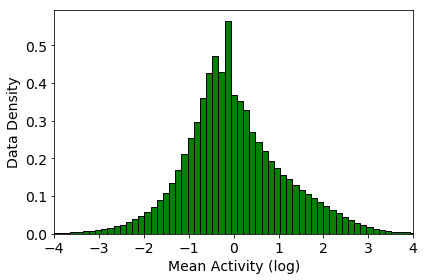

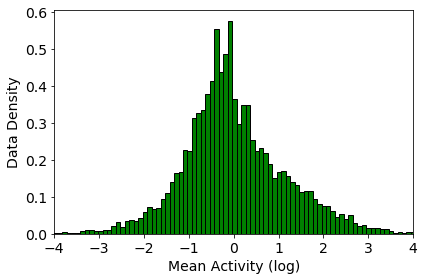

In [4]:
#Histogram of all data

f = plt.figure(figsize=(6, 4))

plt.hist(y_train, bins=100, density=True, color='green', edgecolor='black')

plt.xlim(-4, 4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Mean Activity (log)", fontsize=14)
plt.ylabel("Data Density", fontsize=14)

plt.tight_layout()
plt.show()

f = plt.figure(figsize=(6, 4))

plt.hist(y_test, bins=100, density=True, color='green', edgecolor='black')

plt.xlim(-4, 4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Mean Activity (log)", fontsize=14)
plt.ylabel("Data Density", fontsize=14)

plt.tight_layout()
plt.show()


In [5]:
#Filter on strong(-er) activity

n_train = 52000
n_test = 2000

y_train_sort_index = np.argsort(y_train)[::-1][:n_train]

np.random.shuffle(y_train_sort_index)

x_test = x_train[y_train_sort_index[:n_test]]
y_test = y_train[y_train_sort_index[:n_test]]

x_train = x_train[y_train_sort_index[n_test:n_train]]
y_train = y_train[y_train_sort_index[n_test:n_train]]

print(x_train.shape)
print(x_test.shape)


(50000, 1, 145, 4)
(2000, 1, 145, 4)


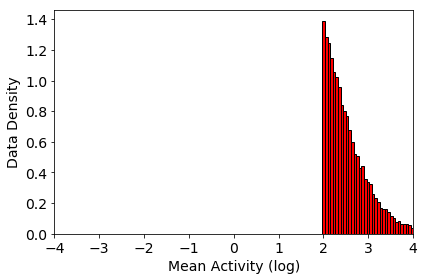

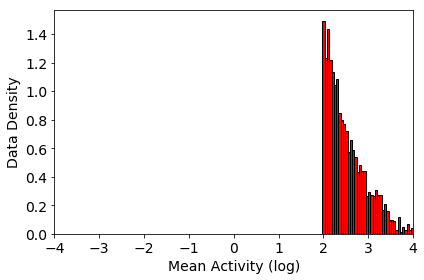

In [6]:
#Histogram of filtered data

f = plt.figure(figsize=(6, 4))

plt.hist(y_train, bins=100, density=True, color='red', edgecolor='black')

plt.xlim(-4, 4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Mean Activity (log)", fontsize=14)
plt.ylabel("Data Density", fontsize=14)

plt.tight_layout()
plt.show()

f = plt.figure(figsize=(6, 4))

plt.hist(y_test, bins=100, density=True, color='red', edgecolor='black')

plt.xlim(-4, 4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Mean Activity (log)", fontsize=14)
plt.ylabel("Data Density", fontsize=14)

plt.tight_layout()
plt.show()


In [7]:

acgt_encoder = IdentityEncoder(145, {'A':0, 'C':1, 'G':2, 'T':3})

seqs_train = [
    acgt_encoder.decode(x_train[i, 0, :, :]) for i in range(x_train.shape[0])
]

seqs_test = [
    acgt_encoder.decode(x_test[i, 0, :, :]) for i in range(x_test.shape[0])
]


In [8]:

with open('mpradragonn_seqs_strong_hepg2.txt', 'wt') as f :
    i = 0
    for seq in seqs_train :
        f.write(seq + "\t" + str(round(y_train[i], 4)) + "\n")
        
        i += 1
